# KNN_SVM_프로모션효율_예측분석

### KNN과 SVM 모델임 어떤 모델인지 공부하여 작성하기

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

# 쇼핑몰 고객 데이터 : 프로모션 쿠폰 발행하고 사용 여부 데이터 수집
- mem : 고객ID, 최근 방문일, 사는 지역, 추천여부, 주요접속채널, 쿠폰 사용여부(Target)
- tran : 고객ID, 구매수량, 총 구매금액
- 전통적 마케팅 분석 기법인 RFM 기법을 활용해 고객 데이터에서 파생변수 생성 후 분석
    - R(Recency) : 현재일 - 최근 구매일
    - F(Frequency) : 구매빈도
    - M(Monetary) : 구매금액
- 종속변수 : conversion 
    - 고객이 프로모션에 반응 했는가?(1(yes)/0(no))

## 데이터 불러오기 및 확인

In [3]:
mem = pd.read_csv('./data/member.csv')
tran = pd.read_csv('./data/transaction.csv')

In [4]:
mem.head(2)
# mem.sample(10)

,id,recency,zip_code,is_referral,channel,conversion
0,906145,10,Surburban,0,Phone,0
1,184478,6,Rural,1,Web,0


In [5]:
tran.head()

,id,num_item,total_amount
0,906145,5,34000
1,906145,1,27000
2,906145,4,33000
3,184478,4,29000
4,394235,4,33000


## 데이터 타입 및 기초 통계량 확인

In [8]:
print(mem.info())
print()
print('='*100)
print()

mem.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64000 entries, 0 to 63999
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           64000 non-null  int64 
 1   recency      64000 non-null  int64 
 2   zip_code     64000 non-null  object
 3   is_referral  64000 non-null  int64 
 4   channel      64000 non-null  object
 5   conversion   64000 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 2.9+ MB
None




,id,recency,is_referral,conversion
count,64000.000000,64000.000000,64000.000000,64000.000000
mean,550694.137797,5.763734,0.502250,0.146781
std,259105.689773,3.507592,0.499999,0.353890
min,100001.000000,1.000000,0.000000,0.000000
25%,326772.000000,2.000000,0.000000,0.000000
50%,551300.000000,6.000000,1.000000,0.000000
75%,774914.500000,9.000000,1.000000,0.000000
max,999997.000000,12.000000,1.000000,1.000000


In [9]:
# 전체 데이터가 숫자형 데이터로 확인
# 고객ID, 구매수량, 총 구매금액
print(tran.info())
print()
print('='*100)
print()

tran.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 196836 entries, 0 to 196835
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype
---  ------        --------------   -----
 0   id            196836 non-null  int64
 1   num_item      196836 non-null  int64
 2   total_amount  196836 non-null  int64
dtypes: int64(3)
memory usage: 4.5 MB
None




,id,num_item,total_amount
count,196836.000000,196836.000000,196836.000000
mean,550557.552932,3.078365,21837.102969
std,259254.795613,1.478408,8218.005565
min,100001.000000,1.000000,8000.000000
25%,326719.000000,2.000000,15000.000000
50%,550918.000000,3.000000,22000.000000
75%,774916.000000,4.000000,29000.000000
max,999997.000000,6.000000,38000.000000


## 결측치 탐지

In [31]:
mem.isna().sum()

id             0
recency        0
zip_code       0
is_referral    0
channel        0
conversion     0
dtype: int64

In [32]:
tran.isna().sum()

id              0
num_item        0
total_amount    0
dtype: int64

## 이상치 탐색 및 처리

<Axes: >

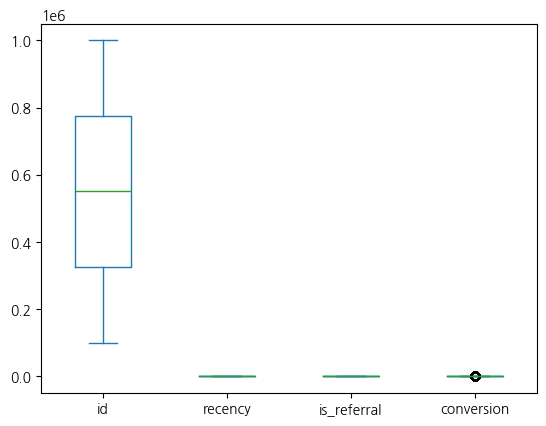

In [56]:
# mem_num의 이상치 확인
mem_num.plot(kind='box')

<Axes: >

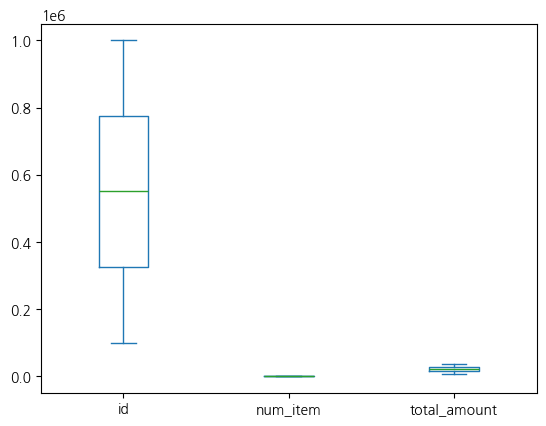

In [61]:
# 이상치 없는 것으로 확인
tran.plot(kind='box')

## EDA(탐색적 데이터 분석)

In [70]:
## 하나의 데이터셋으로 함침
data = pd.merge(tran, mem, how='left', on='id')

In [72]:
data.isna().sum()

id              0
num_item        0
total_amount    0
recency         0
zip_code        0
is_referral     0
channel         0
conversion      0
dtype: int64

In [77]:
len(data[data.duplicated() == True])

1882

In [79]:
# 0.95% 이므로 drop 진행
1882 / len(data) * 100

0.9561259119266801

In [82]:
data = data.drop_duplicates() 

In [62]:
from ydata_profiling import ProfileReport

C:\Users\Admin\miniforge3\envs\fintech\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [137]:
profile = ProfileReport(data, title="Profiling Report")

In [138]:
# profile.to_file("conversion_eda.html")

In [89]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 194954 entries, 0 to 196835
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            194954 non-null  int64 
 1   num_item      194954 non-null  int64 
 2   total_amount  194954 non-null  int64 
 3   recency       194954 non-null  int64 
 4   zip_code      194954 non-null  object
 5   is_referral   194954 non-null  int64 
 6   channel       194954 non-null  object
 7   conversion    194954 non-null  int64 
dtypes: int64(6), object(2)
memory usage: 17.4+ MB


In [92]:
data_obj = data.select_dtypes(include='object')
data_num =  data.select_dtypes(exclude='object')

zip_code
zip_code의 unique 수 : 3
zip_code
Surburban    28776
Urban        25661
Rural         9563
Name: count, dtype: int64



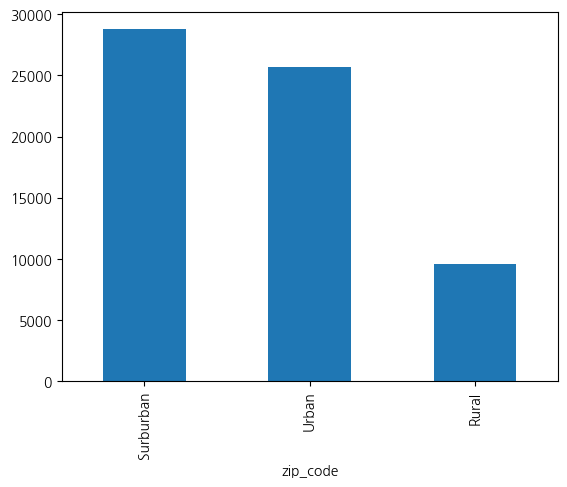

           conversion
zip_code             
Rural        0.211234
Surburban    0.159559
Urban        0.157544


channel
channel의 unique 수 : 3
channel
Web             28217
Phone           28021
Multichannel     7762
Name: count, dtype: int64



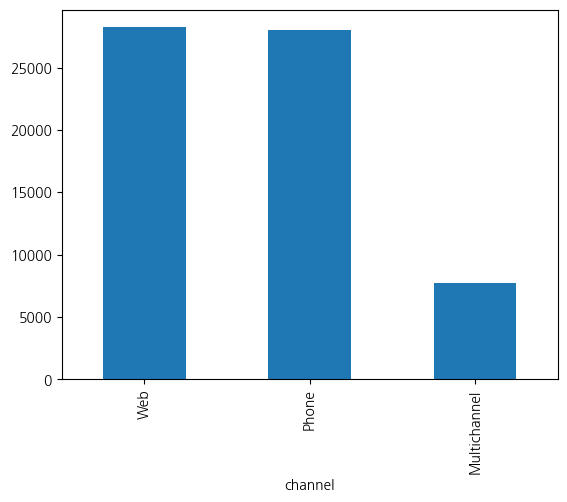

              conversion
channel                 
Multichannel    0.196306
Web             0.180705
Phone           0.144050




In [98]:
for col in data_obj:
    print(col)
    print(f"{col}의 unique 수 : {mem_obj[col].nunique()}", end='\n')
    print(mem_obj[col].value_counts())
    print()
    
    # 시각화
    mem_obj[col].value_counts().plot(kind='bar')
    plt.show()
    
    print(data[[col, 'conversion']].groupby(col).mean().sort_values(by='conversion', ascending=False), end='\n\n')
    print()

id
count    194954.000000
mean     550522.933672
std      259219.615642
min      100001.000000
25%      326731.000000
50%      550835.000000
75%      774844.000000
max      999997.000000
Name: id, dtype: float64




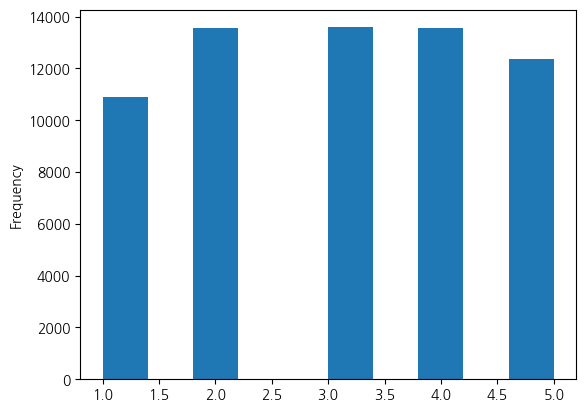

        conversion
id                
525469         1.0
506857         1.0
481242         1.0
491300         1.0
226128         1.0
...            ...
999932         0.0
999981         0.0
999990         0.0
999995         0.0
999997         0.0

[64000 rows x 1 columns]

num_item
count    194954.000000
mean          3.078731
std           1.478383
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           6.000000
Name: num_item, dtype: float64




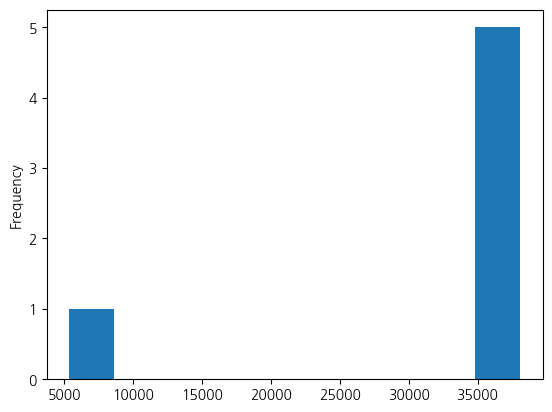

          conversion
num_item            
6           1.000000
4           0.144318
2           0.143941
1           0.143308
3           0.141957
5           0.141090

total_amount
count    194954.000000
mean      21834.699468
std        8218.316453
min        8000.000000
25%       15000.000000
50%       22000.000000
75%       29000.000000
max       38000.000000
Name: total_amount, dtype: float64




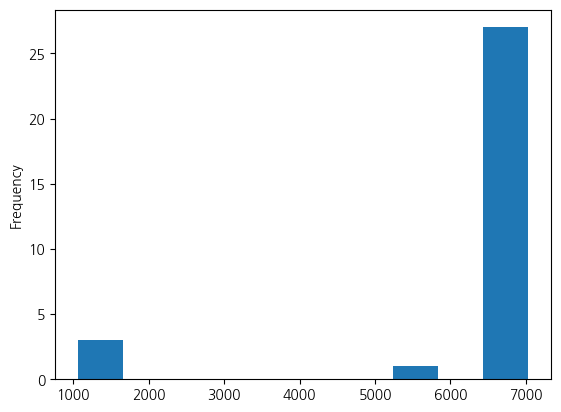

              conversion
total_amount            
37000           1.000000
36000           1.000000
38000           1.000000
34000           0.165760
9000            0.164616
35000           0.162413
14000           0.162033
27000           0.162005
11000           0.160209
19000           0.159699
24000           0.159582
18000           0.159299
21000           0.158199
16000           0.157566
12000           0.157391
22000           0.157181
30000           0.156883
31000           0.156880
23000           0.156736
17000           0.156723
13000           0.156620
15000           0.156525
25000           0.156517
32000           0.154505
20000           0.154191
10000           0.154104
26000           0.152189
33000           0.151546
28000           0.151528
29000           0.148478
8000            0.000000

recency
count    194954.000000
mean          5.754481
std           3.509296
min           1.000000
25%           2.000000
50%           5.000000
75%           9.000000
max  

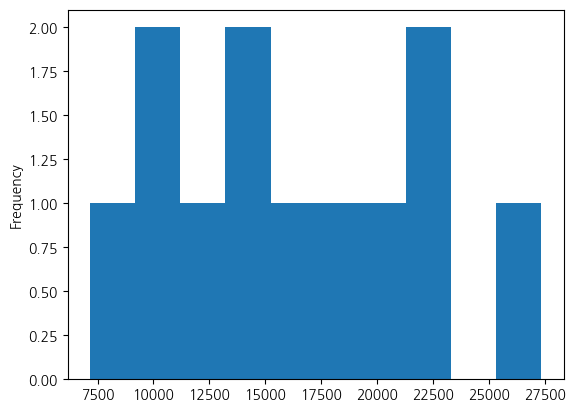

         conversion
recency            
1          0.218190
2          0.202224
3          0.187919
4          0.168835
5          0.163830
6          0.159345
7          0.151011
8          0.146590
12         0.142200
11         0.135693
9          0.130244
10         0.127223

is_referral
count    194954.000000
mean          0.501488
std           0.499999
min           0.000000
25%           0.000000
50%           1.000000
75%           1.000000
max           1.000000
Name: is_referral, dtype: float64




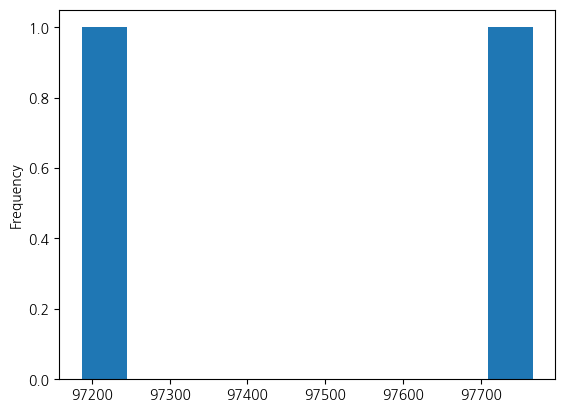

             conversion
is_referral            
0              0.195561
1              0.137725

conversion
count    194954.000000
mean          0.166557
std           0.372581
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max           1.000000
Name: conversion, dtype: float64




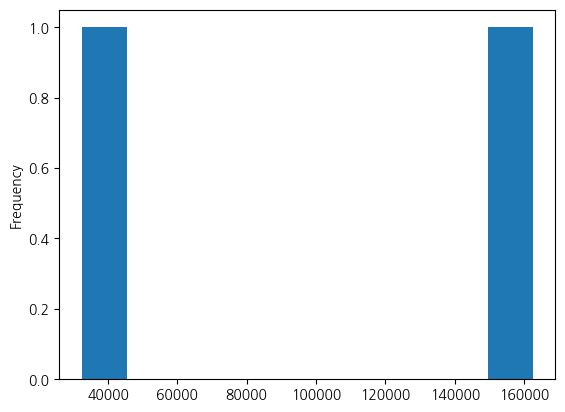

In [112]:
important_cols = []
for col in data_num:
    print(col)
    print(data[col].describe(), end='\n\n')
    print()
    
    # 시각화
    data[col].value_counts().plot(kind='hist')
    plt.show()
    
    if col != 'conversion':
        print(data[[col, 'conversion']].groupby(col).mean().sort_values(by='conversion', ascending=False), end='\n\n')
        ratio_result = data[[col, 'conversion']].groupby(col).mean().sort_values(by='conversion', ascending=False)
        important_cols.append(ratio_result[ratio_result['conversion'] > 0.4].index)
    else:
        pass

In [129]:
final_col = []
for col in important_cols:
#     print(col)
   if len(col) > 0:
        final_col.append(col.name)

In [128]:
# conversion와 영향을 조금이라도 주고 받음 
data.columns

Index(['id', 'num_item', 'total_amount', 'recency', 'zip_code', 'is_referral',
       'channel', 'conversion'],
      dtype='object')

In [132]:
data = data.drop(['recency', 'zip_code', 'is_referral','channel'], axis=1)

In [133]:
data

,id,num_item,total_amount,conversion
0,906145,5,34000,0
1,906145,1,27000,0
2,906145,4,33000,0
3,184478,4,29000,0
4,394235,4,33000,0
...,...,...,...,...
196831,536246,5,24000,1
196832,927617,5,26000,1
196833,927617,3,22000,1
196834,927617,3,18000,1


### 컬럼 확인
문자형 데이터는 0.2가 최대치여서 제외, 그나마 주요하게 영향을 주고 받은 id, num_item, total_amount, conversion을 선정

## 홀드아웃(훈련데이터, 테스트 데이터로 분리)

In [135]:
X = data.drop('conversion', axis=1)
y = data['conversion']

In [156]:
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm       import SVC
from sklearn.metrics import classification_report, roc_auc_score

In [144]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y,random_state=40)

In [157]:
print(len(X_train), len(X_test))
print(len(y_train), len(y_test))

136467 58487
136467 58487


## KNN 분석

In [161]:
knc = KNeighborsClassifier(n_jobs=10)
knc.fit(X_train, y_train)
pred = knc.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.97      0.90     48746
           1       0.43      0.12      0.19      9741

    accuracy                           0.83     58487
   macro avg       0.64      0.54      0.55     58487
weighted avg       0.78      0.83      0.78     58487



In [162]:
for i in range(5,11):
    print('='*30, f"test_result_{i}", '='*30)
    knc = KNeighborsClassifier(n_neighbors=i, n_jobs=10)
    knc.fit(X_train, y_train)
    pred = knc.predict(X_test)

    print(classification_report(y_test, pred))

============================== test_result_5 ==============================
              precision    recall  f1-score   support

           0       0.85      0.97      0.90     48746
           1       0.43      0.12      0.19      9741

    accuracy                           0.83     58487
   macro avg       0.64      0.54      0.55     58487
weighted avg       0.78      0.83      0.78     58487

============================== test_result_6 ==============================
              precision    recall  f1-score   support

           0       0.84      0.99      0.91     48746
           1       0.68      0.09      0.16      9741

    accuracy                           0.84     58487
   macro avg       0.76      0.54      0.53     58487
weighted avg       0.82      0.84      0.79     58487

============================== test_result_7 ==============================
              precision    recall  f1-score   support

           0       0.85      0.98      0.91     48746
         

## SVM 분석

In [11]:
# svc = SVC(class_weight='balanced', n_components=1000,,random_state=40)
# svc.fit(X_train, y_train)
# pred = svc.predict(X_test)

# print(classification_report(y_test, pred))

## DecisionTree 분석

In [151]:
dtc = DecisionTreeClassifier(class_weight='balanced', random_state=40)
dtc.fit(X_train, y_train)
pred = dtc.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.91      0.91      0.91     48746
           1       0.55      0.52      0.54      9741

    accuracy                           0.85     58487
   macro avg       0.73      0.72      0.72     58487
weighted avg       0.85      0.85      0.85     58487



In [150]:
# depth가 올라가면 판별하는 것이 늘어남, 동시에 정확도도 증가됨
# for i in range(1,30):
#     print('='*30, f"test_result_{i}", '='*30)
#     dtc = DecisionTreeClassifier(max_depth=i,class_weight='balanced', random_state=40)
#     dtc.fit(X_train, y_train)
#     pred = dtc.predict(X_test)

#     print(classification_report(y_test, pred))